# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
! pip install -U numpy

In [2]:
! pip install --upgrade setuptools
! pip install --upgrade pip
! pip install xgboost

In [3]:
! pip install imbalanced-learn

In [4]:
!pip install --upgrade scikit-learn

In [5]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, \
    RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from datetime import datetime

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

It's an inbalenced problem

In [8]:
for col in mailout_train.dtypes[mailout_train.dtypes == 'object'].index:
    print(f'{col} = {mailout_train[col].unique()}')

CAMEO_DEU_2015 = ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B'
 '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E'
 '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A'
 '5F' '1B' 'XX']
CAMEO_DEUG_2015 = [5.0 2.0 7.0 4.0 nan 3.0 6.0 1.0 8.0 9.0 '4' '6' '2' '9' '8' '7' '3' '1'
 '5' 'X']
CAMEO_INTL_2015 = [34.0 32.0 14.0 41.0 24.0 33.0 nan 25.0 31.0 22.0 43.0 13.0 55.0 23.0 54.0
 51.0 45.0 12.0 44.0 35.0 15.0 52.0 '23' '44' '14' '55' '51' '45' '43'
 '22' '54' '24' '25' '13' '12' '35' '33' '41' '15' '52' '31' '32' '34'
 'XX']
D19_LETZTER_KAUF_BRANCHE = ['D19_UNBEKANNT' 'D19_TELKO_MOBILE' 'D19_LEBENSMITTEL'
 'D19_BEKLEIDUNG_GEH' 'D19_BUCH_CD' nan 'D19_NAHRUNGSERGAENZUNG'
 'D19_SCHUHE' 'D19_SONSTIGE' 'D19_HAUS_DEKO' 'D19_FREIZEIT' 'D19_ENERGIE'
 'D19_VOLLSORTIMENT' 'D19_BANKEN_REST' 'D19_VERSICHERUNGEN'
 'D19_KINDERARTIKEL' 'D19_TECHNIK' 'D19_DROGERIEARTIKEL'
 'D19_BEKLEIDUNG_REST' 'D19_WEIN_FEINKOST' 'D19_HANDWERK' 'D19_GARTE

The CAMEO_DEUG_2015 and CAMEO_INTL_2015 should be numeric, so I will replace the 'X' and 'XX' for -1

In [9]:
mailout_train['CAMEO_DEUG_2015'] = pd.to_numeric(mailout_train['CAMEO_DEUG_2015'].replace('X', -1))
mailout_train['CAMEO_INTL_2015'] = pd.to_numeric(mailout_train['CAMEO_INTL_2015'].replace('XX', -1))

In [10]:
percentage_of_na = mailout_train.isna().sum() / mailout_train.shape[0]
percentage_of_na = percentage_of_na.sort_values(ascending=False)
percentage_of_na.describe()

count    367.000000
mean       0.140621
std        0.126460
min        0.000000
25%        0.000000
50%        0.185327
75%        0.185327
max        0.999046
dtype: float64

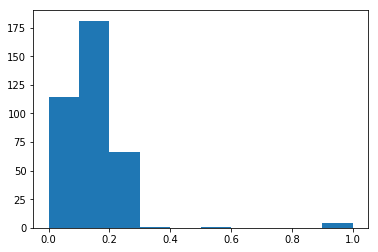

In [11]:
plt.hist(percentage_of_na);

In [12]:
percentage_of_na[percentage_of_na < 0.15].index

Index(['RT_UEBERGROESSE', 'HH_EINKOMMEN_SCORE', 'CJT_TYP_6', 'CJT_TYP_5',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'RT_SCHNAEPPCHEN',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN',
       ...
       'D19_VERSAND_REST', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM',
       'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'LNR'],
      dtype='object', length=115)

In [13]:
percentage_of_na['KK_KUNDENTYP']

0.5892649318001956

From the above columns, I only could find the meaning of KK_KUNDENTYP at Excel spreadsheets, so all other I gonna drop and fill with -1 the nan cells of KK_KUNDENTYP

In [14]:
mailout_train['KK_KUNDENTYP'] = mailout_train['KK_KUNDENTYP'].fillna(-1)

In [15]:
mailout_train_filtered = mailout_train.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1'], axis=1)

In [16]:
mailout_train_filtered[mailout_train_filtered.dtypes[mailout_train_filtered.dtypes == 'object'].index] = mailout_train_filtered[mailout_train_filtered.dtypes[mailout_train_filtered.dtypes == 'object'].index].apply(lambda x: x.fillna(value='-1'))
mailout_train_filtered[mailout_train_filtered.dtypes[mailout_train_filtered.dtypes != 'object'].index] = mailout_train_filtered[mailout_train_filtered.dtypes[mailout_train_filtered.dtypes != 'object'].index].apply(lambda x: x.fillna(value=-1))

In [17]:
le = LabelEncoder()

In [18]:
obj_cols = mailout_train_filtered.dtypes[mailout_train.dtypes == 'object'].index

In [19]:
mailout_train_filtered[obj_cols] = mailout_train_filtered[obj_cols].apply(le.fit_transform)

In [20]:
X = mailout_train_filtered.drop('RESPONSE', axis=1)
y = mailout_train_filtered['RESPONSE']

In [21]:
X = RobustScaler().fit_transform(X)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
pipe = Pipeline([('pca', PCA()), ('xgb_reg', XGBRegressor())])

In [24]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA()),
                ('xgb_reg',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=1, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [25]:
y_preds = pipe.predict(X_val)

In [26]:
print(roc_auc_score(y_val, y_preds))

0.632594022822919


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [27]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
mailout_test['KK_KUNDENTYP'] = mailout_test['KK_KUNDENTYP'].fillna(-1)

In [29]:
mailout_test['CAMEO_DEUG_2015'] = pd.to_numeric(mailout_test['CAMEO_DEUG_2015'].replace('X', -1))
mailout_test['CAMEO_INTL_2015'] = pd.to_numeric(mailout_test['CAMEO_INTL_2015'].replace('XX', -1))

In [30]:
mailout_test[mailout_test.dtypes[mailout_test.dtypes == 'object'].index] = mailout_test[mailout_test.dtypes[mailout_test.dtypes == 'object'].index].apply(lambda x: x.fillna(value='-1'))
mailout_test[mailout_test.dtypes[mailout_test.dtypes != 'object'].index] = mailout_test[mailout_test.dtypes[mailout_test.dtypes != 'object'].index].apply(lambda x: x.fillna(value=-1))

In [31]:
mailout_test = mailout_test.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1'], axis=1)

In [32]:
le = LabelEncoder()

In [33]:
obj_cols = mailout_test.dtypes[mailout_test.dtypes == 'object'].index

In [34]:
mailout_test[obj_cols] = mailout_test[obj_cols].apply(le.fit_transform)

In [35]:
X = RobustScaler().fit_transform(mailout_test)

In [36]:
y_preds_test = pipe.predict(X)

In [37]:
y_preds_test[y_preds_test < 0] = 0

In [38]:
y_preds_test[y_preds_test > 1] = 1

In [39]:
response = mailout_test[['LNR']]

In [40]:
response['RESPONSE'] = y_preds_test

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
response.to_csv('response3.csv', index=False)